In [1]:
import pandas as pd
import re
import os
import numpy as np 
import xlrd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [2]:
def get_species(x):
    species = x.split(" ")[0]
    return(species)  

In [3]:
def get_plate(x):
    species = str(int(x.split("-")[1]))
    return(species)  

In [4]:
def listToString(s):  
    '''transform list to string, sep by "_". '''
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s: 
        if str1 == "":
            str1 += ele
        else:
            str1 += '_'
            str1 += ele
    
    # return string   
    return str1  

In [5]:
def get_species_for_group(id_group):
    '''get species name foreach qseqid group'''
#     filtered_cover = id_group[id_group['coverage'] >= 0.9]
    filtered_cover = id_group[id_group['alignlen'] >= 900]
    sp = ""
    if len(filtered_cover) >0:
        filtered_ident = filtered_cover[filtered_cover['pident'] >= 98.4]
        if len(filtered_ident) >0:
            filtered_ident = filtered_ident.sort_values(by="pident" , ascending=False)
            sp = filtered_ident.iloc[0].sscinames
        else:
            filtered_ident_90 = filtered_cover[filtered_cover['pident'] >= 90]
            spec = list(map(get_species,filtered_ident_90.sscinames.tolist()))
            sps = list(set(spec))
            if len(sps) == 1:
                sp = sps[0] + " sp."
            else:
                sp = "unknown"
    else:
        sp = "unknown"
    return(sp)

In [6]:
def annotated_species(file, dict_wellID, dict_label, path = "/home/mlk442/FIND/oo7433/MicroMGx_rpoB/"):
    '''Generate species annoated output file. Input should be a Plate*_consensus_blastn.out file'''
    file_path = path + file
    file_plate = file.split("_")[0]
    plateID = file_plate.split("Plate")[1]
    df = pd.read_csv(file_path, sep='\t',header=None)
    head_csv = path +"header.tsv"
    output = file_path.replace(".out", "_out_annoated.csv")
    header = pd.read_csv(head_csv, sep='\t')
    df.columns = header.columns
    df["coverage"] = df.alignlen/df.qlen
    output_list = []
    qids = list(set(df.qseqid.unique().tolist()))
    df_grouped = df.groupby("qseqid")
    for ind in range(len(qids)):
        plate_type = ""
        id_group = df_grouped.get_group(qids[ind])
        info =qids[ind].split("_")
        key_dict_wellID = info[0].split(file_plate)[1]
        w_ID = dict_wellID[key_dict_wellID]
        key_dict_label = str(plateID) + " "+w_ID
        label = dict_label[key_dict_label]
        if info[3] < info[2]:
            plate_type = "mixed"
        if info[3] == info[2]:
            plate_type = "pure"
        spec = get_species_for_group(id_group)
        output_list.append([qids[ind],label,plate_type, spec])

    output_table = pd.DataFrame()
    output_table = output_table.append(output_list)
    output_table.columns= ['qseqid','materialLable', 'plate_type', 'Species_genus']           
    output_table = output_table.sort_values(by="qseqid" , ascending=False)
    #output_table.to_csv(output, index=False)
    return(output_table)

In [7]:
file = '/home/mlk442/FIND/oo7433/MicroMGx_rpoB/2020_16S_IDs_06112020.xlsx'
wb = xlrd.open_workbook(filename=file)
print(wb.sheet_names())
master_sheet = wb.sheet_by_name('Master')
master_sheet

['Notes', 'Master', 'Blank', 'Control', 'MGxSelected', 'Non-MGx', '605_45', '16SMetrics', 'Composition', 'Sources', 'Targeted']


In [8]:
plate = master_sheet.col_values(1)
plate.pop(0)
wellID = master_sheet.col_values(2)
wellID.pop(0)
materialLable = master_sheet.col_values(8)
materialLable.pop(0)
plateID = list(map(get_plate,plate ))

'Plate'

'384 Well ID'

'MaterialLabel'

In [9]:
plate_well = list(map(lambda x :x[0]+ " "+x[1] ,zip(plateID,wellID)))
dict_label = dict(zip(plate_well,materialLable ))

In [10]:
f = '/home/mlk442/FIND/oo7433/MicroMGx_rpoB/rpoB_consensus_blastn06262020.xlsx'
wb = xlrd.open_workbook(filename=f)
print(wb.sheet_names())
consolidated = wb.sheet_by_name('Plate1_consolidated_blastn')
consolidated

['Notes', 'Plate1_consensus_blastn', 'Plate1_consolidated_blastn', 'Plate1_All', 'AllPlates']


In [11]:
full_plateID = consolidated.col_values(8)
full_plateID.pop(0)
each_plateID = list(map(lambda x : x.split("Plate1")[1],full_plateID ))
consolidated_C= consolidated.col_values(11)
consolidated_C.pop(0)
consolidated_R= consolidated.col_values(12)
consolidated_R.pop(0)
consolidated_wellID = list(map(lambda x :x[0]+ str(int(x[1])).zfill(2),zip(consolidated_C,consolidated_R)))
dict_wellID = dict(zip(each_plateID, consolidated_wellID))

''

'C'

'R'

In [12]:
def create_taxon(qseqids, species):
    percents = list(map(lambda x : " ("+str(x.split("_")[3])+"/"+str(x.split("_")[2])+")",qseqids))
    num_perc = list(map(lambda x : float(x.split("_")[3])/float(x.split("_")[2]),qseqids))
    #join and sort taxonomy if mutiple gene cluster belong to the same well 
    df = pd.DataFrame()
    df["spec"] = species
    df['perc'] = percents
    df['perc_num'] = num_perc
    new_df = df.sort_values(by="perc_num" , ascending=False)   
    sorted_spec = new_df.spec.tolist()
    sorted_perc = new_df.perc.tolist()

    taxons = list(map(lambda x : x[0] + x[1], zip(sorted_spec, sorted_perc )))
    final_taxon = "; ".join(taxons)
    return(final_taxon)

In [13]:
plate = 1
tab_1 = 3
tab_2 = 4

In [14]:
file = f"Plate{plate}_consensus_blastn.out"
plate_result = annotated_species(file,dict_wellID,dict_label)
plate_result

,qseqid,materialLable,plate_type,Species_genus
440,Plate1D.H11_Cluster.1_50_50_1076,DA976Z3139,pure,Amycolatopsis sp.
352,Plate1D.H10_Singleton.1_1_1_936,DA976Z3014,pure,unknown
26,Plate1D.H09_Singleton.2_2_1_1383,DA976Z2928,mixed,unknown
32,Plate1D.H09_Singleton.1_2_1_1000,DA976Z2928,mixed,Streptomyces globisporus
347,Plate1D.H08_Cluster.1_2_2_1945,DA976Z2958,pure,Streptomyces globisporus
...,...,...,...,...
317,Plate1A.A06_Singleton.1_7_1_2199,DB182A0068,mixed,Pseudomonas sp.
270,Plate1A.A06_Cluster.2_7_3_1177,DB182A0068,mixed,Pseudomonas mosselii
394,Plate1A.A06_Cluster.1_7_3_1961,DB182A0068,mixed,Streptomyces globisporus C-1027
278,Plate1A.A05_Cluster.1_50_50_950,DA005L0001,pure,Streptomyces globisporus


In [15]:
def plate_result_wellID(plate_result):
    plate_result["sequence_ID"] = list(map(lambda x : x.split("_")[0],plate_result.qseqid.tolist() ))
    seq_IDs = list(set(plate_result.sequence_ID.unique().tolist()))
    seq_grouped = plate_result.groupby("sequence_ID")
    plate_list = []
    for i in range(len(seq_IDs)):
        seq_group = seq_grouped.get_group(seq_IDs[i])
        if len(seq_group) == 1:
            line = seq_group.qseqid.tolist()[0].split('_')
            well_type = "P"
            taxonomy = seq_group.Species_genus.tolist()[0] + " (" +str(line[3])+'/'+str(line[2]) +")"
        else:
            qseqids = seq_group.qseqid.tolist()
            species = seq_group.Species_genus.tolist()
            taxonomy = create_taxon(qseqids, species)
            well_type = "M"
        strainID = seq_group.materialLable.tolist()[0]
        t = f'Plate{plate}'
        wellID = dict_wellID[seq_IDs[i].split(t)[1]]
        plate_list.append([seq_IDs[i], wellID, strainID, well_type, taxonomy])
    
    plate_table = pd.DataFrame()
    plate_table = plate_table.append(plate_list)
    plate_table.columns= ['sequenceID', 'wellID','strainID', 'wellType', 'Taxonomy']           
    plate_table = plate_table.sort_values(by="sequenceID" , ascending=True)
    return(plate_table)

In [16]:
plate_result_wellID(plate_result)

,sequenceID,wellID,strainID,wellType,Taxonomy
57,Plate1A.A04,A07,DA011H0004,P,Streptomyces globisporus C-1027 (50/50)
221,Plate1A.A05,A09,DA005L0001,P,Streptomyces globisporus (50/50)
159,Plate1A.A06,A11,DB182A0068,M,Pseudomonas mosselii (3/7); Streptomyces globi...
138,Plate1A.A07,A13,DA021U0004,P,Streptomyces globisporus (2/2)
183,Plate1A.A08,A15,DB182A0026,P,Amycolatopsis keratiniphila (1/1)
...,...,...,...,...,...
190,Plate1D.H07,P14,DA976Z2973,P,Streptomyces globisporus (2/2)
168,Plate1D.H08,P16,DA976Z2958,P,Streptomyces globisporus (2/2)
107,Plate1D.H09,P18,DA976Z2928,M,unknown (1/2); Streptomyces globisporus (1/2)
164,Plate1D.H10,P20,DA976Z3014,P,unknown (1/1)


In [17]:
def transform_plate_table(plate_table):
    # Add all 384 wellID, if well is blank, keep the other columns NaN
    for q in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']:
        for ID in range(1, 25):
            wellID = q + f'{ID:02d}'
            if wellID not in set(plate_table['wellID'].to_list()):
                line = ['', wellID, '', '', '']
                plate_table = plate_table.append(pd.Series(line, index = plate_table.columns), ignore_index = True)
    plate_table = plate_table.sort_values(by = 'wellID')
    return(plate_table)

In [18]:
def read_16s( plateN, path_16s ="/home/mlk442/FIND/MicroMGx_2020/amplicons/MicroMGx_16S" ):
    #Function to extract 16s taxonomy with wellID matched
    df = pd.DataFrame()
    for i in ['A', 'B','C','D']:
        filename = 'plate' + str(plateN) + i+"_consensus.tophit_1line.txt"
        read_16s = pd.read_table(path_16s +'/plate' + str(plateN) + i+"_consensus.tophit_1line.txt")
        well = list(map(lambda x: x[-3],read_16s["Plate.Well"].tolist()))
        well_num = list(map(lambda x: str(int(x[-2:])),read_16s["Plate.Well"].tolist()))
        well_ID_16s = list(map(lambda x: i+x[0]+x[1], zip(well,well_num)))
        wellID = list(map(lambda x: dict_quad_wellID[x], well_ID_16s))
        d = {'plateWell': wellID,'16S': read_16s["TOPBLAST (Cluster/Total)"].tolist()} 
        plat_df= pd.DataFrame(d)
        df = df.append(plat_df)
    df = df.sort_values(by = ['plateWell'])
    return (df) 

In [19]:
path_16s = "/home/mlk442/FIND/MicroMGx_2020/amplicons/MicroMGx_16S"
f = '/home/mlk442/FIND/oo7433/MicroMGx_rpoB/MicroMGx_16s_vs_WGS1.xlsx'
wb = xlrd.open_workbook(filename=f)
# print(wb.sheet_names())
others = wb.sheet_by_name('MicroMGx_16s_vs_WGS')
well_384 = others.col_values(0)[2:]
quad = others.col_values(1)[2:]
quad = ["A" if x =="Q1" else x  for x in quad]
quad = ["B" if x =="Q2" else x  for x in quad]
quad = ["C" if x =="Q3" else x  for x in quad]
quad = ["D" if x =="Q4" else x  for x in quad]
well_96= others.col_values(2)[2:]
dict_quad_wellID = dict(zip(list(map(lambda x: x[0]+x[1], zip(quad, well_96))), well_384))

In [20]:
# run for all rpoB plates with 16s taxonomy added
# Here, plate1 is used as showcase
path = "/home/mlk442/FIND/mlk442/MicroMGx_rpoB/"
files= os.listdir(path)
out_files = list(filter(lambda x: re.search("\.out", x) != None, files))
for file in out_files:
    plate_N = file.split("_")[0].split("Plate")[1]
    if plate_N == '1':
        plate_result = annotated_species(file,dict_wellID,dict_label )
        plate_table = plate_result_wellID(plate_result)
        plate_table_rpob_16s = transform_plate_table(plate_table)
        plate_table_rpob_16s["16S"] = read_16s(plate_N)['16S'].tolist()
        plate_table_rpob_16s

,sequenceID,wellID,strainID,wellType,Taxonomy,16S
268,,A01,,,,NaN
269,,A02,,,,Streptomyces angustmyceticus (2/2)
270,,A03,,,,Nonomuraea jabiensis (5/5)
271,,A04,,,,NaN
272,,A05,,,,Streptomyces canus (20/20)
...,...,...,...,...,...,...
266,Plate1D.H10,P20,DA976Z3014,P,unknown (1/1),Nocardioides albus (49/50)
382,,P21,,,,NaN
267,Plate1D.H11,P22,DA976Z3139,P,Amycolatopsis sp. (50/50),Amycolatopsis decaplanina (50/50)
200,Plate1C.H12,P23,DA976Z3132,P,Streptomyces globisporus C-1027 (1/1),NaN


In [21]:
f = '/home/mlk442/FIND/oo7433/MicroMGx_rpoB/MicroMGx_16s_vs_WGS1.xlsx'
wb = xlrd.open_workbook(filename=f)
# print(wb.sheet_names())
others = wb.sheet_by_name('MicroMGx_16s_vs_WGS')
rrna = others.col_values(tab_1)[2:]
wgs = others.col_values(tab_2)[2:]
plate_table = transform_plate_table(plate_table)
plate_table['16S'] = rrna
plate_table['WGS'] = wgs

In [22]:
plate_table_excel = plate_table

In [23]:
plate_table_rpob_16s

,sequenceID,wellID,strainID,wellType,Taxonomy,16S
268,,A01,,,,NaN
269,,A02,,,,Streptomyces angustmyceticus (2/2)
270,,A03,,,,Nonomuraea jabiensis (5/5)
271,,A04,,,,NaN
272,,A05,,,,Streptomyces canus (20/20)
...,...,...,...,...,...,...
266,Plate1D.H10,P20,DA976Z3014,P,unknown (1/1),Nocardioides albus (49/50)
382,,P21,,,,NaN
267,Plate1D.H11,P22,DA976Z3139,P,Amycolatopsis sp. (50/50),Amycolatopsis decaplanina (50/50)
200,Plate1C.H12,P23,DA976Z3132,P,Streptomyces globisporus C-1027 (1/1),NaN


In [24]:
def read_16s( plateN, path_16s ="/home/mlk442/FIND/MicroMGx_2020/amplicons/MicroMGx_16S" ):
    'Function to extract 16s taxonomy with wellID matched'
    df = pd.DataFrame()
    for i in ['A', 'B','C','D']:
        filename = 'plate' + str(plateN) + i+"_consensus.tophit_1line.txt"
        read_16s = pd.read_table(path_16s +'/plate' + str(plateN) + i+"_consensus.tophit_1line.txt")
        well = list(map(lambda x: x[-3],read_16s["Plate.Well"].tolist()))
        well_num = list(map(lambda x: str(int(x[-2:])),read_16s["Plate.Well"].tolist()))
        well_ID_16s = list(map(lambda x: i+x[0]+x[1], zip(well,well_num)))
        wellID = list(map(lambda x: dict_quad_wellID[x], well_ID_16s))
        d = {'plateWell': wellID,'16S': read_16s["TOPBLAST (Cluster/Total)"].tolist()} 
        plat_df= pd.DataFrame(d)
        df = df.append(plat_df)
    df = df.sort_values(by = ['plateWell'])
    return (df)      

In [25]:
plate_table[plate_table['16S'] != ''].shape
plate_table[((plate_table['Taxonomy'] != '') & (~plate_table['Taxonomy'].str.contains('unknown')))].shape
plate_table[plate_table['WGS'] != ''].shape
plate_table[((plate_table['Taxonomy'] != '') & (~plate_table['Taxonomy'].str.contains('unknown'))) | \
            (plate_table['16S'] != '') | (plate_table['WGS'] != '')].shape

(289, 7)

(219, 7)

(86, 7)

(330, 7)

In [26]:
plate_table[((plate_table['Taxonomy'] != '') & (~plate_table['Taxonomy'].str.contains('unknown'))) & \
            (plate_table['16S'] != '') & (plate_table['WGS'] != '')].shape

(48, 7)

In [27]:
others

In [28]:
# run for all rpoB plates
path = "/home/mlk442/FIND/mlk442/MicroMGx_rpoB/"
files= os.listdir(path)
out_files = list(filter(lambda x: re.search("\.out", x) != None, files))
for file in out_files:
    plate_N = file.split("_")[0].split("Plate")[1]
    if plate_N == '1':
        plate_result = annotated_species(file,dict_wellID,dict_label )
        plate_table = plate_result_wellID(plate_result)
        plate_table_rpob_16s = transform_plate_table(plate_table)
        plate_table_rpob_16s["16S"] = read_16s(plate_N)['16S'].tolist()
        plate_table_rpob_16s

,sequenceID,wellID,strainID,wellType,Taxonomy,16S
268,,A01,,,,NaN
269,,A02,,,,Streptomyces angustmyceticus (2/2)
270,,A03,,,,Nonomuraea jabiensis (5/5)
271,,A04,,,,NaN
272,,A05,,,,Streptomyces canus (20/20)
...,...,...,...,...,...,...
266,Plate1D.H10,P20,DA976Z3014,P,unknown (1/1),Nocardioides albus (49/50)
382,,P21,,,,NaN
267,Plate1D.H11,P22,DA976Z3139,P,Amycolatopsis sp. (50/50),Amycolatopsis decaplanina (50/50)
200,Plate1C.H12,P23,DA976Z3132,P,Streptomyces globisporus C-1027 (1/1),NaN


In [29]:
plate_table

,sequenceID,wellID,strainID,wellType,Taxonomy
57,Plate1A.A04,A07,DA011H0004,P,Streptomyces globisporus C-1027 (50/50)
221,Plate1A.A05,A09,DA005L0001,P,Streptomyces globisporus (50/50)
159,Plate1A.A06,A11,DB182A0068,M,Pseudomonas mosselii (3/7); Streptomyces globi...
138,Plate1A.A07,A13,DA021U0004,P,Streptomyces globisporus (2/2)
183,Plate1A.A08,A15,DB182A0026,P,Amycolatopsis keratiniphila (1/1)
...,...,...,...,...,...
190,Plate1D.H07,P14,DA976Z2973,P,Streptomyces globisporus (2/2)
168,Plate1D.H08,P16,DA976Z2958,P,Streptomyces globisporus (2/2)
107,Plate1D.H09,P18,DA976Z2928,M,unknown (1/2); Streptomyces globisporus (1/2)
164,Plate1D.H10,P20,DA976Z3014,P,unknown (1/1)


In [30]:
def get_taxon(l):
    new_list=[]
    for i in range(len(l)):
        if l[i] == '':
            new_list.append('')
        else:
            genus = l[i].split(' ')[3]
            new_list.append(genus)
    return (new_list)
    
    

In [31]:
plate_table

,sequenceID,wellID,strainID,wellType,Taxonomy
57,Plate1A.A04,A07,DA011H0004,P,Streptomyces globisporus C-1027 (50/50)
221,Plate1A.A05,A09,DA005L0001,P,Streptomyces globisporus (50/50)
159,Plate1A.A06,A11,DB182A0068,M,Pseudomonas mosselii (3/7); Streptomyces globi...
138,Plate1A.A07,A13,DA021U0004,P,Streptomyces globisporus (2/2)
183,Plate1A.A08,A15,DB182A0026,P,Amycolatopsis keratiniphila (1/1)
...,...,...,...,...,...
190,Plate1D.H07,P14,DA976Z2973,P,Streptomyces globisporus (2/2)
168,Plate1D.H08,P16,DA976Z2958,P,Streptomyces globisporus (2/2)
107,Plate1D.H09,P18,DA976Z2928,M,unknown (1/2); Streptomyces globisporus (1/2)
164,Plate1D.H10,P20,DA976Z3014,P,unknown (1/1)


In [32]:
from collections import Counter 
taxon_rpoB = plate_table_excel.Taxonomy.tolist()
genus_rpoB = list(map(lambda X: X.split(" ")[0], taxon_rpoB))
taxon_16s = plate_table_excel["16S"].tolist()
genus_16s = list(map(lambda X: X.split(" ")[0], taxon_16s))
taxon_WGS = plate_table_excel["WGS"].tolist()
genus_WGS = get_taxon(taxon_WGS)

In [33]:
rpoB_16s = list(map(lambda x: x[0] == x[1], zip(genus_rpoB, genus_16s)))
Counter(rpoB_16s)

Counter({True: 195, False: 189})

In [34]:
rpoB_WGS = list(map(lambda x: x[0] == x[1] and x[0] != '', zip(genus_rpoB, genus_WGS)))
Counter(rpoB_WGS)

Counter({False: 347, True: 37})

In [35]:
S_WGS = list(map(lambda x: x[0] == x[1] and x[0] != '', zip(genus_16s, genus_WGS)))
Counter(S_WGS)

Counter({False: 306, True: 78})

In [36]:
S_rpob_WGS = list(map(lambda x: x[0] == x[1] and x[0] != '' and x[1]==x[2], zip(genus_16s, genus_rpoB, genus_WGS)))
Counter(S_rpob_WGS)

Counter({False: 347, True: 37})

In [37]:
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as pl

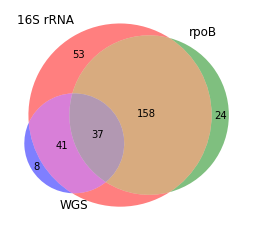

In [38]:
venn3(subsets = (53, 24, 158, 8, 41, 0, 37), set_labels = ('16S rRNA', 'rpoB', 'WGS'), alpha = 0.5);